# Multi-task GPs in GPyTorch
Simple notebook, trying to get to grips with 
   1. Multi-task GPs
   2. Variational approximation in GPyTorch
   
I have a good grasp of MOGPs already, so I'll start with the Variational inference first and see if I can get somewhere. 

I've read the initial papers concerning sparse GPs with inducing points, as well as done some implementations myself in C++ for the single-output case. Now will have to see if I can reproduce that analysis using gpytorch.


## Exact GP implementation

In [1]:
# Start with some imports
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt

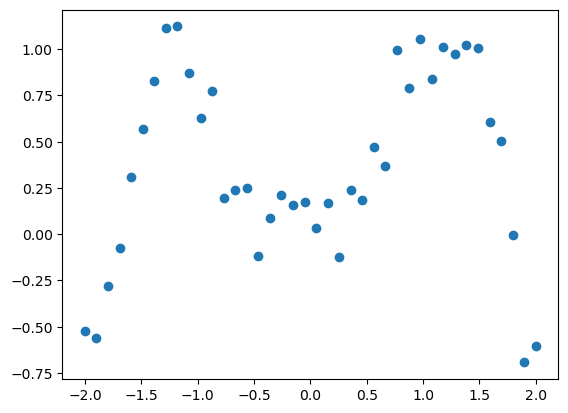

In [2]:
# Genererate some mock data that will be simple to fit 
x = torch.linspace(-2,2,40)
f = np.sin(x**2)
sigma = 0.2
y = f + sigma*torch.randn(f.size())
plt.plot(x,y,"o")

In [3]:
# Now fitting a GP to this
# Need to set up my model first
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self,train_x,train_y,likelihood):
        super(ExactGPModel, self).__init__(train_x,train_y,likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x,y,likelihood)

In [4]:
# Set up optimization scheme

# Number of iterations of optimizer
training_iter = 50

# Set model in train
model.train()
likelihood.train()
# Optimizeer
optimizer = torch.optim.Adam(model.parameters(),lr=0.1)
# Define loss function
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,model)

# Then train
for i in range(training_iter):
    # Zero gradients
    optimizer.zero_grad()
    # Output from model 
    output = model(x)
    # Calculate loss
    loss = -mll(output,y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.959   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.929   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.898   lengthscale: 0.600   noise: 0.598
Iter 4/50 - Loss: 0.867   lengthscale: 0.563   noise: 0.554
Iter 5/50 - Loss: 0.836   lengthscale: 0.534   noise: 0.513
Iter 6/50 - Loss: 0.805   lengthscale: 0.517   noise: 0.474
Iter 7/50 - Loss: 0.773   lengthscale: 0.507   noise: 0.437
Iter 8/50 - Loss: 0.742   lengthscale: 0.501   noise: 0.403
Iter 9/50 - Loss: 0.711   lengthscale: 0.494   noise: 0.371
Iter 10/50 - Loss: 0.680   lengthscale: 0.482   noise: 0.340
Iter 11/50 - Loss: 0.649   lengthscale: 0.467   noise: 0.312
Iter 12/50 - Loss: 0.619   lengthscale: 0.450   noise: 0.286
Iter 13/50 - Loss: 0.589   lengthscale: 0.436   noise: 0.262
Iter 14/50 - Loss: 0.559   lengthscale: 0.427   noise: 0.240
Iter 15/50 - Loss: 0.529   lengthscale: 0.425   noise: 0.219
Iter 16/50 - Loss: 0.498   lengthscale: 0.427   noise: 0.200
Iter 17/50 - Loss: 0.468   length

In [5]:
# Now making predictions on a finer grid
x.test = torch.linspace(-2,2,500)

# Get model into eval mode
model.eval()
likelihood.eval()

# Predicting
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x.test))


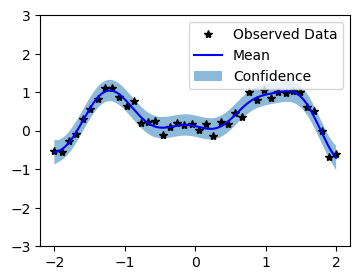

In [6]:
# Plotting
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(x.numpy(), y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x.test.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x.test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

## Variational approximation

Variational inference takes place within another model class in GPyTorch -- `ApproximateGP`, and needs a few new objects to get going.
   1. `VariationalDistribution`, defining the form of the approximate inducing value posterior $q(\mathbf{u})$
   2. `VariationalStrategies`, defining how to compute $p(\mathbf{f}(\mathbf{X}))$ from $q(\mathbf{u})$. That is, the forward method defined how $\int p(f\vert \mathbf{x},\mathbf{u})q(\mathbf{u})\text{d}\mathbf{u}$ should be computed.

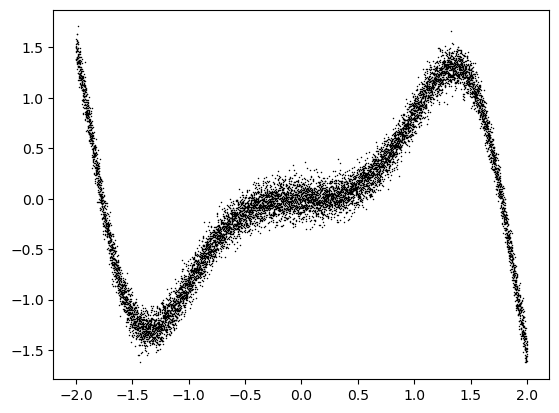

In [7]:
# Using the same function as before, we will simply add some more datapoints
x = torch.linspace(-2,2,10000)
f_true = np.sin(x**2)*x
sigma = 0.1
y = f_true + sigma*torch.randn(f_true.size())
plt.plot(x,y,"k*",markersize=.5)

In [14]:
# And now define the approximate model
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(self,inducing_points,variational_distribution, learn_inducing_locations=True)
        super(GPModel,self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)
inducing_points = torch.linspace(-2,2,100)
model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [15]:
model.train()
likelihood.train()
with gpytorch.settings.verbose_linalg(True):
    output = model(x)

LinAlg (Verbose) - DEBUG - Running Cholesky on a matrix of size torch.Size([100, 100]).


In [177]:
# Set up optimization scheme

# Number of iterations of optimizer
training_iter = 1000

# Set model in train
model.train()
likelihood.train()
# Optimizeer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)
# Define loss function
mll = gpytorch.mlls.VariationalELBO(likelihood,model,num_data = y.size(0))

# Keeping track of loss
m = []
eps = 1e-4
diff = 10

# Then train
for i in range(training_iter):
    # Zero gradients
    optimizer.zero_grad()
    # Output from model 
    output = model(x)
    # Calculate loss
    loss = -mll(output,y)
    loss.backward()
    m.append(loss.item())
    if i > 0:
        diff = abs(m[i]-m[i-1])
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f loss difference: %.4f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        likelihood.noise.item(),
        diff
    ))
    optimizer.step()
    if diff < eps:
        print('Model converged!')
        break

Iter 1/1000 - Loss: -0.096   lengthscale: 0.640   noise: 0.084 loss difference: 10.0000
Iter 2/1000 - Loss: 2.232   lengthscale: 0.635   noise: 0.084 loss difference: 2.3281
Iter 3/1000 - Loss: -0.058   lengthscale: 0.639   noise: 0.084 loss difference: 2.2901
Iter 4/1000 - Loss: -0.021   lengthscale: 0.642   noise: 0.084 loss difference: 0.0369
Iter 5/1000 - Loss: 0.094   lengthscale: 0.643   noise: 0.085 loss difference: 0.1151
Iter 6/1000 - Loss: 0.161   lengthscale: 0.643   noise: 0.085 loss difference: 0.0668
Iter 7/1000 - Loss: 0.190   lengthscale: 0.642   noise: 0.085 loss difference: 0.0288
Iter 8/1000 - Loss: 0.196   lengthscale: 0.639   noise: 0.085 loss difference: 0.0059
Iter 9/1000 - Loss: 0.191   lengthscale: 0.636   noise: 0.085 loss difference: 0.0052
Iter 10/1000 - Loss: 0.180   lengthscale: 0.633   noise: 0.085 loss difference: 0.0104
Iter 11/1000 - Loss: 0.166   lengthscale: 0.630   noise: 0.085 loss difference: 0.0144
Iter 12/1000 - Loss: 0.150   lengthscale: 0.627 

Iter 99/1000 - Loss: -0.355   lengthscale: 0.611   noise: 0.054 loss difference: 0.0046
Iter 100/1000 - Loss: -0.361   lengthscale: 0.612   noise: 0.053 loss difference: 0.0057
Iter 101/1000 - Loss: -0.364   lengthscale: 0.613   noise: 0.053 loss difference: 0.0036
Iter 102/1000 - Loss: -0.369   lengthscale: 0.613   noise: 0.052 loss difference: 0.0045
Iter 103/1000 - Loss: -0.374   lengthscale: 0.614   noise: 0.052 loss difference: 0.0051
Iter 104/1000 - Loss: -0.377   lengthscale: 0.615   noise: 0.051 loss difference: 0.0031
Iter 105/1000 - Loss: -0.382   lengthscale: 0.615   noise: 0.051 loss difference: 0.0052
Iter 106/1000 - Loss: -0.386   lengthscale: 0.615   noise: 0.050 loss difference: 0.0036
Iter 107/1000 - Loss: -0.390   lengthscale: 0.615   noise: 0.050 loss difference: 0.0045
Iter 108/1000 - Loss: -0.394   lengthscale: 0.615   noise: 0.049 loss difference: 0.0040
Iter 109/1000 - Loss: -0.398   lengthscale: 0.615   noise: 0.049 loss difference: 0.0039
Iter 110/1000 - Loss: 

In [178]:
# Now making predictions on a finer grid
x.test = torch.linspace(-2,2,500)

# Get model into eval mode
model.eval()
likelihood.eval()

# Predicting
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x.test))


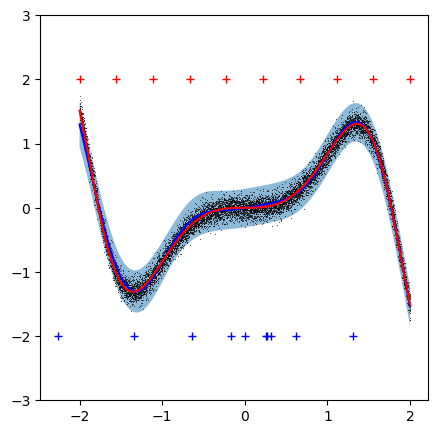

In [179]:
# Plotting
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(5, 5))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(x.numpy(), y.numpy(), 'k*',markersize=0.1)
    # Plot predictive means as blue line
    ax.plot(x.test.numpy(), observed_pred.mean.numpy(), 'b')
    ax.plot(x.numpy(),f_true.numpy(), "r")
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x.test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])
    # Add original and learning inducing locations
    ax.plot(inducing_points, torch.full((inducing_points.shape),2.0),'r+')
    ax.plot(model.variational_strategy.pseudo_points[1], torch.full((model.variational_strategy.pseudo_points[1].shape),-2.0),'b+')

Sure, I think I have a fairly decent grasp now on how some of these things work. How about the multi-output case?

## Variational Multi-output models